# Decision trees, overarching aims


We start here with the most basic algorithm, the so-called decision
tree. With this basic algorithm we can in turn build more complex
networks, spanning from homogeneous and heterogenous forests (bagging,
random forests and more) to one of the most popular supervised
algorithms nowadays, the extreme gradient boosting, or just
XGBoost. But let us start with the simplest possible ingredient.

Decision trees are supervised learning algorithms used for both,
classification and regression tasks.


The main idea of decision trees
is to find those descriptive features which contain the most
**information** regarding the target feature and then split the dataset
along the values of these features such that the target feature values
for the resulting underlying datasets are as pure as possible.

The descriptive features which reproduce best the target/output features are normally  said
to be the most informative ones. The process of finding the **most
informative** feature is done until we accomplish a stopping criteria
where we then finally end up in so called **leaf nodes**. 

## Basics of a tree

A decision tree is typically divided into a **root node**, the **interior nodes**,
and the final **leaf nodes** or just **leaves**. These entities are then connected by so-called **branches**.

The leaf nodes
contain the predictions we will make for new query instances presented
to our trained model. This is possible since the model has 
learned the underlying structure of the training data and hence can,
given some assumptions, make predictions about the target feature value
(class) of unseen query instances.


## General Features

The overarching approach to decision trees is a top-down approach.

* A leaf provides the classification of a given instance.

* A node specifies a test of some attribute of the instance.

* A branch corresponds to a possible values of an attribute.

* An instance is classified by starting at the root node of the tree, testing the attribute specified by this node, then moving down the tree branch corresponding to the value of the attribute in the given example.

This process is then repeated for the subtree rooted at the new
node.



In simplified terms, the process of training a decision tree and
predicting the target features of query instances is as follows:

1. Present a dataset containing of a number of training instances characterized by a number of descriptive features and a target feature

2. Train the decision tree model by continuously splitting the target feature along the values of the descriptive features using a measure of information gain during the training process

3. Grow the tree until we accomplish a stopping criteria create leaf nodes which represent the *predictions* we want to make for new query instances

4. Show query instances to the tree and run down the tree until we arrive at leaf nodes

Then we are essentially done!

2nd degree coefficients:
zero power:  4.0618352118150005
first power:  0.004339135748752641
second power:  1.9543538503067644e-05


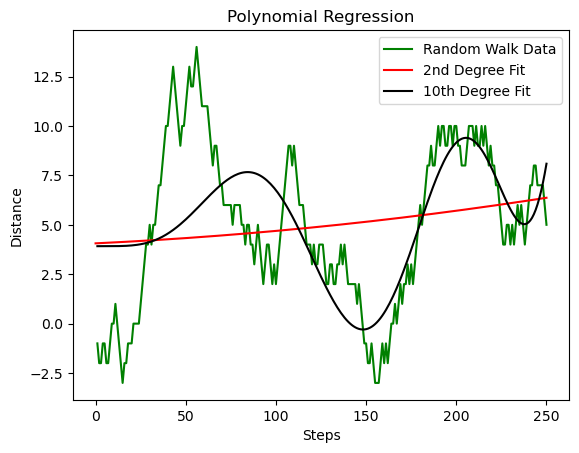

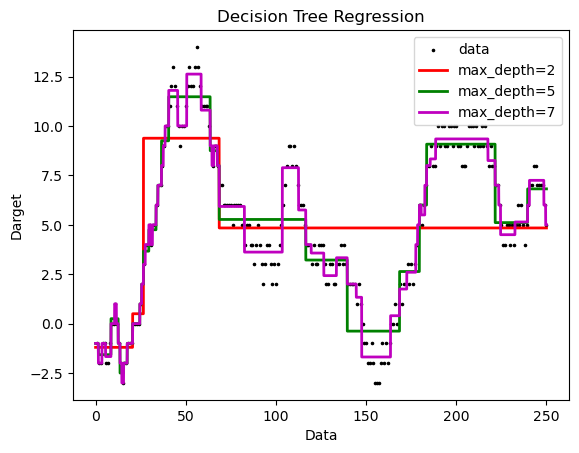

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

steps=250

distance=0
x=0
distance_list=[]
steps_list=[]
while x<steps:
    distance+=np.random.randint(-1,2)
    distance_list.append(distance)
    x+=1
    steps_list.append(x)
plt.plot(steps_list,distance_list, color='green', label="Random Walk Data")

steps_list=np.asarray(steps_list)
distance_list=np.asarray(distance_list)

X=steps_list[:,np.newaxis]

#Polynomial fits

#Degree 2
poly_features=PolynomialFeatures(degree=2, include_bias=False)
X_poly=poly_features.fit_transform(X)

lin_reg=LinearRegression()
poly_fit=lin_reg.fit(X_poly,distance_list)
b=lin_reg.coef_
c=lin_reg.intercept_
print ("2nd degree coefficients:")
print ("zero power: ",c)
print ("first power: ", b[0])
print ("second power: ",b[1])

z = np.arange(0, steps, .01)
z_mod=b[1]*z**2+b[0]*z+c

fit_mod=b[1]*X**2+b[0]*X+c
plt.plot(z, z_mod, color='r', label="2nd Degree Fit")
plt.title("Polynomial Regression")

plt.xlabel("Steps")
plt.ylabel("Distance")

#Degree 10
poly_features10=PolynomialFeatures(degree=10, include_bias=False)
X_poly10=poly_features10.fit_transform(X)

poly_fit10=lin_reg.fit(X_poly10,distance_list)

y_plot=poly_fit10.predict(X_poly10)
plt.plot(X, y_plot, color='black', label="10th Degree Fit")

plt.legend()
plt.show()


#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
regr_1=DecisionTreeRegressor(max_depth=2)
regr_2=DecisionTreeRegressor(max_depth=5)
regr_3=DecisionTreeRegressor(max_depth=7)
regr_1.fit(X, distance_list)
regr_2.fit(X, distance_list)
regr_3.fit(X, distance_list)

X_test = np.arange(0.0, steps, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3=regr_3.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, distance_list, s=2.5, c="black", label="data")
plt.plot(X_test, y_1, color="red",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="green", label="max_depth=5", linewidth=2)
plt.plot(X_test, y_3, color="m", label="max_depth=7", linewidth=2)

plt.xlabel("Data")
plt.ylabel("Darget")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Building a tree, regression

There are mainly two steps
1. We split the predictor space (the set of possible values $x_1,x_2,\dots, x_p$) into $J$ distinct and non-non-overlapping regions, $R_1,R_2,\dots,R_J$.  

2. For every observation that falls into the region $R_j$ , we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

How do we construct the regions $R_1,\dots,R_J$?  In theory, the
regions could have any shape. However, we choose to divide the
predictor space into high-dimensional rectangles, or boxes, for
simplicity and for ease of interpretation of the resulting predictive
model. The goal is to find boxes $R_1,\dots,R_J$ that minimize the
MSE, given by

$$
\sum_{j=1}^J\sum_{i\in R_j}(y_i-\overline{y}_{R_j})^2,
$$

where $\overline{y}_{R_j}$  is the mean response for the training observations 
within box $j$. 


Unfortunately, it is computationally infeasible to consider every
possible partition of the feature space into $J$ boxes.  The common
strategy is to take a top-down approach

The approach is top-down because it begins at the top of the tree (all
observations belong to a single region) and then successively splits
the predictor space; each split is indicated via two new branches
further down on the tree. It is greedy because at each step of the
tree-building process, the best split is made at that particular step,
rather than looking ahead and picking a split that will lead to a
better tree in some future step.


### Making a tree

In order to implement the recursive binary splitting we start by selecting
the predictor $x_j$ and a cutpoint $s$ that splits the predictor space into two regions $R_1$ and $R_2$

$$
\left\{X\vert x_j < s\right\},
$$

and

$$
\left\{X\vert x_j \geq s\right\},
$$

so that we obtain the lowest MSE, that is

$$
\sum_{i:x_i\in R_j}(y_i-\overline{y}_{R_1})^2+\sum_{i:x_i\in R_2}(y_i-\overline{y}_{R_2})^2,
$$

which we want to minimize by considering all predictors
$x_1,x_2,\dots,x_p$.  We consider also all possible values of $s$ for
each predictor. These values could be determined by randomly assigned
numbers or by starting at the midpoint and then proceed till we find
an optimal value.

For any $j$ and $s$, we define the pair of half-planes where
$\overline{y}_{R_1}$ is the mean response for the training
observations in $R_1(j,s)$, and $\overline{y}_{R_2}$ is the mean
response for the training observations in $R_2(j,s)$.

Finding the values of $j$ and $s$ that minimize the above equation can be
done quite quickly, especially when the number of features $p$ is not
too large.

Next, we repeat the process, looking
for the best predictor and best cutpoint in order to split the data
further so as to minimize the MSE within each of the resulting
regions. However, this time, instead of splitting the entire predictor
space, we split one of the two previously identified regions. We now
have three regions. Again, we look to split one of these three regions
further, so as to minimize the MSE. The process continues until a
stopping criterion is reached; for instance, we may continue until no
region contains more than five observations.


The above procedure is rather straightforward, but leads often to
overfitting and unnecessarily large and complicated trees. The basic
idea is to grow a large tree $T_0$ and then prune it back in order to
obtain a subtree. A smaller tree with fewer splits (fewer regions) can
lead to smaller variance and better interpretation at the cost of a
little more bias.

The so-called Cost complexity pruning algorithm gives us a
way to do just this. Rather than considering every possible subtree,
we consider a sequence of trees indexed by a nonnegative tuning
parameter $\alpha$.

Read more at the following [Scikit-Learn link on pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py).


For each value of $\alpha$  there corresponds a subtree $T \in T_0$ such that

$$
\sum_{m=1}^{\overline{T}}\sum_{i:x_i\in R_m}(y_i-\overline{y}_{R_m})^2+\alpha\overline{T},
$$

is as small as possible. Here $\overline{T}$ is 
the number of terminal nodes of the tree $T$ , $R_m$ is the
rectangle (i.e. the subset of predictor space)  corresponding to the $m$-th terminal node.

The tuning parameter $\alpha$ controls a trade-off between the subtree’s
complexity and its fit to the training data. When $\alpha = 0$, then the
subtree $T$ will simply equal $T_0$, 
because then the above equation just measures the
training error. 
However, as $\alpha$ increases, there is a price to pay for
having a tree with many terminal nodes. The above equation will
tend to be minimized for a smaller subtree. 


It turns out that as we increase $\alpha$ from zero
branches get pruned from the tree in a nested and predictable fashion,
so obtaining the whole sequence of subtrees as a function of $\alpha$ is
easy. We can select a value of $\alpha$ using a validation set or using
cross-validation. We then return to the full data set and obtain the
subtree corresponding to $\alpha$. 


### Schematic Regression Procedure

Building a Regression Tree

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.

2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.

3. Use for example $K$-fold cross-validation to choose $\alpha$. Divide the training observations into $K$ folds. For each $k=1,2,\dots,K$ we: 

  * repeat steps 1 and 2 on all but the $k$-th fold of the training data. 

  * Then we valuate the mean squared prediction error on the data in the left-out $k$-th fold, as a function of $\alpha$.

  * Finally  we average the results for each value of $\alpha$, and pick $\alpha$ to minimize the average error.


4. Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$. 

!eblock



## A Classification Tree

A classification tree is very similar to a regression tree, except
that it is used to predict a qualitative response rather than a
quantitative one. Recall that for a regression tree, the predicted
response for an observation is given by the mean response of the
training observations that belong to the same terminal node. In
contrast, for a classification tree, we predict that each observation
belongs to the most commonly occurring class of training observations
in the region to which it belongs. In interpreting the results of a
classification tree, we are often interested not only in the class
prediction corresponding to a particular terminal node region, but
also in the class proportions among the training observations that
fall into that region.  



The task of growing a
classification tree is quite similar to the task of growing a
regression tree. Just as in the regression setting, we use recursive
binary splitting to grow a classification tree. However, in the
classification setting, the MSE cannot be used as a criterion for making
the binary splits.  A natural alternative to MSE is the **classification
error rate**. Since we plan to assign an observation in a given region
to the most commonly occurring error rate class of training
observations in that region, the classification error rate is simply
the fraction of the training observations in that region that do not
belong to the most common class. 

When building a classification tree, either the Gini index or the
entropy are typically used to evaluate the quality of a particular
split, since these two approaches are more sensitive to node purity
than is the classification error rate. 



If our targets are the outcome of a classification process that takes
for example $k=1,2,\dots,K$ values, the only thing we need to think of
is to set up the splitting criteria for each node.

We define a PDF $p_{mk}$ that represents the number of observations of
a class $k$ in a region $R_m$ with $N_m$ observations. We represent
this likelihood function in terms of the proportion $I(y_i=k)$ of
observations of this class in the region $R_m$ as

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i=k).
$$

We let $p_{mk}$ represent the majority class of observations in region
$m$. The three most common ways of splitting a node are given by

* Misclassification error

$$
p_{mk} = \frac{1}{N_m}\sum_{x_i\in R_m}I(y_i\ne k) = 1-p_{mk}.
$$

* Gini index $g$

$$
g = \sum_{k=1}^K p_{mk}(1-p_{mk}).
$$

* Information entropy or just entropy $s$

$$
s = -\sum_{k=1}^K p_{mk}\log{p_{mk}}.
$$

### Visualizing the Tree, Classification

In [2]:
import os
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from IPython.display import Image 
from pydot import graph_from_dot_data
import pandas as pd
import numpy as np


cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
print(X)
y = pd.Categorical.from_codes(cancer.target, cancer.target_names)
y = pd.get_dummies(y)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file="DataFiles/cancer.dot",
    feature_names=cancer.feature_names,
    class_names=cancer.target_names,
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/cancer.dot -o DataFiles/cancer.png'
os.system(cmd)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mea

0

In [3]:
# Common imports
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data
import pandas as pd
import os

np.random.seed(42)
X, y = make_moons(n_samples=100, noise=0.25, random_state=53)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=5)
tree_clf.fit(X_train, y_train)

export_graphviz(
    tree_clf,
    out_file="DataFiles/moons.dot",
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/moons.dot -o DataFiles/moons.png'
os.system(cmd)

0

### Other ways of visualizing the trees

**Scikit-Learn** has also another way to visualize the trees which is very useful, here with the Iris data.

[Text(0.5, 0.9166666666666666, 'X[2] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5769230769230769, 0.75, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3076923076923077, 0.5833333333333334, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.46153846153846156, 0.08333333333333333, 'gini

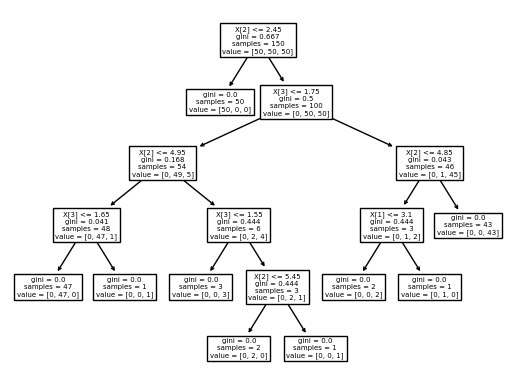

In [4]:
from sklearn.datasets import load_iris
from sklearn import tree
X, y = load_iris(return_X_y=True)
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X, y)
# and then plot the tree
tree.plot_tree(tree_clf)

Alternatively, the tree can also be exported in textual format with the function exporttext.
This method doesn’t require the installation of external libraries and is more compact:

In [5]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
iris = load_iris()
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(iris.data, iris.target)
r = export_text(decision_tree, feature_names=iris['feature_names'])
print(r)

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- class: 1
|   |--- petal width (cm) >  1.75
|   |   |--- class: 2



## Algorithms for Setting up Decision Trees

Two algorithms stand out in the set up of decision trees:
1. The CART (Classification And Regression Tree) algorithm for both classification and regression

2. The ID3 algorithm based on the computation of the information gain for classification

We discuss both algorithms with applications here. The popular library
**Scikit-Learn** uses the CART algorithm. For classification problems
you can use either the **gini** index or the **entropy** to split a tree
in two branches.

### The CART algorithm for Classification

For classification, the CART algorithm splits the data set in two subsets using a single feature $k$ and a threshold $t_k$.
This could be for example a threshold set by a number below a certain circumference of a malign tumor.

How do we find these two quantities?
We search for the pair $(k,t_k)$ that produces the purest subset using for example the **gini** factor $G$.
The cost function it tries to minimize is then

$$
C(k,t_k) = \frac{m_{\mathrm{left}}}{m}G_{\mathrm{left}}+ \frac{m_{\mathrm{right}}}{m}G_{\mathrm{right}},
$$

where $G_{\mathrm{left/right}}$ measures the impurity of the left/right subset  and $m_{\mathrm{left/right}}$
 is the number of instances in the left/right subset

Once it has successfully split the training set in two, it splits the subsets using the same logic, then the subsubsets
and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the
$max\_depth$ hyperparameter), or if it cannot find a split that will reduce impurity. A few other
hyperparameters control additional stopping conditions such as the $min\_samples\_split$,
$min\_samples\_leaf$, $min\_weight\_fraction\_leaf$, and $max\_leaf\_nodes$.


### The CART algorithm for Regression

The CART algorithm for regression works is similar to the one for classification except that instead of trying to split the
training set in a way that minimizes say the **gini** or **entropy** impurity, it now tries to split the training set in a way that minimizes our well-known mean-squared error (MSE). The cost function is now

$$
C(k,t_k) = \frac{m_{\mathrm{left}}}{m}\mathrm{MSE}_{\mathrm{left}}+ \frac{m_{\mathrm{right}}}{m}\mathrm{MSE}_{\mathrm{right}}.
$$

Here the MSE for a specific node is defined as

$$
\mathrm{MSE}_{\mathrm{node}}=\frac{1}{m_\mathrm{node}}\sum_{i\in \mathrm{node}}(\overline{y}_{\mathrm{node}}-y_i)^2,
$$

with

$$
\overline{y}_{\mathrm{node}}=\frac{1}{m_\mathrm{node}}\sum_{i\in \mathrm{node}}y_i,
$$

the mean value of all observations in a specific node.

Without any regularization, the regression task for decision trees, 
just like for classification tasks, is  prone to overfitting.



### Computing the Gini index

The example we will look at is a classical one in many Machine
Learning applications. Based on various meteorological features, we
have several so-called attributes which decide whether we at the end
will do some outdoor activity like skiing, going for a bike ride etc
etc.  The table here contains the feautures **outlook**, **temperature**,
**humidity** and **wind**.  The target or output is whether we ride
(True=1) or whether we do something else that day (False=0). The
attributes for each feature are then sunny, overcast and rain for the
outlook, hot, cold and mild for temperature, high and normal for
humidity and weak and strong for wind.

The table here summarizes the various attributes and
<table border="1">
<thead>
<tr><th align="center">Day</th> <th align="center">Outlook </th> <th align="center">Temperature</th> <th align="center">Humidity</th> <th align="center"> Wind </th> <th align="center">Ride</th> </tr>
</thead>
<tbody>
<tr><td align="center">   1      </td> <td align="center">   Sunny       </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   2      </td> <td align="center">   Sunny       </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   3      </td> <td align="center">   Overcast    </td> <td align="center">   Hot            </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   4      </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   5      </td> <td align="center">   Rain        </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   6      </td> <td align="center">   Rain        </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   7      </td> <td align="center">   Overcast    </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   8      </td> <td align="center">   Sunny       </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Weak      </td> <td align="center">   0       </td> </tr>
<tr><td align="center">   9      </td> <td align="center">   Sunny       </td> <td align="center">   Cool           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   10     </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   11     </td> <td align="center">   Sunny       </td> <td align="center">   Mild           </td> <td align="center">   Normal      </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   12     </td> <td align="center">   Overcast    </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   13     </td> <td align="center">   Overcast    </td> <td align="center">   Hot            </td> <td align="center">   Normal      </td> <td align="center">   Weak      </td> <td align="center">   1       </td> </tr>
<tr><td align="center">   14     </td> <td align="center">   Rain        </td> <td align="center">   Mild           </td> <td align="center">   High        </td> <td align="center">   Strong    </td> <td align="center">   0       </td> </tr>
</tbody>
</table>

### Simple Python Code to read in Data and perform Classification

In [6]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import Image 
from pydot import graph_from_dot_data
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("rideclass.csv"),'r')

# Read the experimental data with Pandas
from IPython.display import display
ridedata = pd.read_csv(infile,names = ('Outlook','Temperature','Humidity','Wind','Ride'))
ridedata = pd.DataFrame(ridedata)

# Features and targets
X = ridedata.loc[:, ridedata.columns != 'Ride'].values
y = ridedata.loc[:, ridedata.columns == 'Ride'].values

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore")
# Assume for simplicity all features are categorical.
encoder.fit(X)    
# Apply the encoder.
X = encoder.transform(X)
print(X)
# Then do a Classification tree
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)
print("Train set accuracy with Decision Tree: {:.2f}".format(tree_clf.score(X,y)))
#transfer to a decision tree graph
export_graphviz(
    tree_clf,
    out_file="DataFiles/ride.dot",
    rounded=True,
    filled=True
)
cmd = 'dot -Tpng DataFiles/cancer.dot -o DataFiles/cancer.png'
os.system(cmd)

FileNotFoundError: [Errno 2] No such file or directory: 'DataFiles/rideclass.csv'

The above functions (gini, entropy and misclassification error) are
important components of the so-called CART algorithm. We will discuss
this algorithm below after we have discussed the information gain
algorithm ID3.

In the example here we have converted all our attributes into numerical values $0,1,2$ etc.

In [ ]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
dataset = [[0,0,0,0,0],
            [0,0,0,1,1],
            [1,0,0,0,1],
            [2,1,0,0,1],
            [2,2,1,0,1],
            [2,2,1,1,0],
            [1,2,1,1,1],
            [0,1,0,0,0],
            [0,2,1,0,1],
            [2,1,1,0,1],
            [0,1,1,1,1],
            [1,1,0,1,1],
            [1,0,1,0,1],
            [2,1,0,1,0]]

split = get_split(dataset)
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

## Entropy and the ID3 algorithm

The ID3 algorithm  learns decision trees by constructing
them in a top down way, beginning with the question **which attribute should be tested at the root of the tree**?

1. Each instance attribute is evaluated using a statistical test to determine how well it alone classifies the training examples.

2. The best attribute is selected and used as the test at the root node of the tree.

3. A descendant of the root node is then created for each possible value of this attribute.

4. Training examples are sorted to the appropriate descendant node.

5. The entire process is then repeated using the training examples associated with each descendant node to select the best attribute to test at that point in the tree.

6. This forms a greedy search for an acceptable decision tree, in which the algorithm never backtracks to reconsider earlier choices. 

The ID3 algorithm selects which attribute to test at each node in the
tree.

We would like to select the attribute that is most useful for classifying
examples.

What is a good quantitative measure of the worth of an attribute?

Information gain measures how well a given attribute separates the
training examples according to their target classification.

The ID3 algorithm uses this information gain measure to select among the candidate
attributes at each step while growing the tree.


### Cancer Data again now with Decision Trees and other Methods

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
# Support vector machine
svm = SVC(gamma='auto', C=100)
svm.fit(X_train, y_train)
print("Test set accuracy with SVM: {:.2f}".format(svm.score(X_test,y_test)))
# Decision Trees
deep_tree_clf = DecisionTreeClassifier(max_depth=None)
deep_tree_clf.fit(X_train, y_train)
print("Test set accuracy with Decision Trees: {:.2f}".format(deep_tree_clf.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Support Vector Machine
svm.fit(X_train_scaled, y_train)
print("Test set accuracy SVM with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))
# Decision Trees
deep_tree_clf.fit(X_train_scaled, y_train)
print("Test set accuracy with Decision Trees and scaled data: {:.2f}".format(deep_tree_clf.score(X_test_scaled,y_test)))

### Another example, the moons again

In [ ]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from sklearn.svm import SVC
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.tree import export_graphviz

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)


def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.show()

In [ ]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi/4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

plt.show()

In [ ]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

## Pros and cons of trees, pros

* White box, easy to interpret model. Some people believe that decision trees more closely mirror human decision-making than do the regression and classification approaches discussed earlier (think of support vector machines)

* Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!

* No feature normalization needed

* Tree models can handle both continuous and categorical data (Classification and Regression Trees)

* Can model nonlinear relationships

* Can model interactions between the different descriptive features

* Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small)

### Disadvantages

* Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classification approaches

* If continuous features are used the tree may become quite large and hence less interpretable

* Decision trees are prone to overfit the training data and hence do not well generalize the data if no stopping criteria or improvements like pruning, boosting or bagging are implemented

* Small changes in the data may lead to a completely different tree. This issue can be addressed by using ensemble methods like bagging, boosting or random forests

* Unbalanced datasets where some target feature values occur much more frequently than others may lead to biased trees since the frequently occurring feature values are preferred over the less frequently occurring ones. 

* If the number of features is relatively large (high dimensional) and the number of instances is relatively low, the tree might overfit the data

* Features with many levels may be preferred over features with less levels since for them it is *more easy* to split the dataset such that the sub datasets only contain pure target feature values. This issue can be addressed by preferring for instance the information gain ratio as splitting criteria over information gain

However, by aggregating many decision trees, using methods like
bagging, random forests, and boosting, the predictive performance of
trees can be substantially improved.